# Red Sox Game Analysis

This file examines post-game entries at Kenmore station in comparison to expectations.

## Setup    

In [133]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [233]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

## Data

### Read

In [140]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
# sox.game_time = sox.game_time.astype(dt.time)
# sox.game_time_rounded = sox.game_time_rounded.astype(dt.time)

In [141]:
sox.head()

,game_date,game_time,opponent,game_datetime,game_time_rounded,game_datetime_rounded
0,2012-04-13,02:05 PM,Rays,2012-04-13 14:05:00,02:00 PM,2012-04-13 14:00:00
1,2012-04-14,04:05 PM,Rays,2012-04-14 16:05:00,04:00 PM,2012-04-14 16:00:00
2,2012-04-15,01:35 PM,Rays,2012-04-15 13:35:00,01:30 PM,2012-04-15 13:30:00
3,2012-04-16,11:05 AM,Rays,2012-04-16 11:05:00,11:00 AM,2012-04-16 11:00:00
4,2012-04-17,07:10 PM,Rangers,2012-04-17 19:10:00,07:00 PM,2012-04-17 19:00:00


In [156]:
# Import gatecount data.
def get_data():
    return pd.DataFrame.from_csv("../../../data/mbta.csv").reset_index()
gatecount = date.init(get_data())

# Restrict to Kenmore and the columns that we need.
kenmore = gatecount.ix[gatecount.locationid==1059,['service_day','service_datetime','entries']].reset_index(drop=True)

# Turn days/dates into datetimes.
kenmore.service_day = pd.to_datetime(kenmore.service_day)
kenmore.service_datetime = pd.to_datetime(kenmore.service_datetime)

# Get time of day.
kenmore['service_time'] = pd.DatetimeIndex(kenmore.service_datetime).time

# Add day of week.
kenmore = date.add_day_of_week(kenmore.copy())

In [157]:
kenmore.head()

,service_day,service_datetime,entries,service_time,day_of_week
0,2013-01-01,2013-01-01 05:30:00,6,05:30:00,1
1,2013-01-01,2013-01-01 05:45:00,2,05:45:00,1
2,2013-01-01,2013-01-01 06:00:00,5,06:00:00,1
3,2013-01-01,2013-01-01 06:15:00,16,06:15:00,1
4,2013-01-01,2013-01-01 06:30:00,8,06:30:00,1


In [164]:
kenmore.service_time > dt.time(23,31)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
...
65034    False
65035    False
65036     True
65037    False
65038    False
65039    False
65040    False
65041    False
65042    False
65043    False
65044    False
65045    False
65046    False
65047    False
65048    False
Name: service_time, Length: 65049, dtype: bool

### Merge

In [171]:
# Perform merge.
kenmore_games = kenmore.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
kenmore_games['game_played'] = (kenmore_games.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
kenmore_games['time_since_game_start'] = kenmore_games.service_datetime - kenmore_games.game_datetime_rounded

In [181]:
kenmore_games[kenmore_games.game_played].head()

,service_day,service_datetime,entries,service_time,day_of_week,game_date,game_time,opponent,game_datetime,game_time_rounded,game_datetime_rounded,game_played,time_since_game_start
7987,2013-04-08,2013-04-08 03:00:00,0,03:00:00,0,2013-04-08,02:05 PM,Orioles,2013-04-08 14:05:00,02:00 PM,2013-04-08 14:00:00,True,-11:00:00
7988,2013-04-08,2013-04-08 03:15:00,0,03:15:00,0,2013-04-08,02:05 PM,Orioles,2013-04-08 14:05:00,02:00 PM,2013-04-08 14:00:00,True,-10:45:00
7989,2013-04-08,2013-04-08 04:45:00,2,04:45:00,0,2013-04-08,02:05 PM,Orioles,2013-04-08 14:05:00,02:00 PM,2013-04-08 14:00:00,True,-09:15:00
7990,2013-04-08,2013-04-08 05:00:00,2,05:00:00,0,2013-04-08,02:05 PM,Orioles,2013-04-08 14:05:00,02:00 PM,2013-04-08 14:00:00,True,-09:00:00
7991,2013-04-08,2013-04-08 05:15:00,20,05:15:00,0,2013-04-08,02:05 PM,Orioles,2013-04-08 14:05:00,02:00 PM,2013-04-08 14:00:00,True,-08:45:00


## Game Exploration 

Let's figure out when games happen.

In [84]:
# Copy DF for this analysis.
sox_only = sox.copy()
# Add weekday.
sox_only['day_of_week'] = pd.DatetimeIndex(sox_only.game_date).weekday

When do games occur during the week? **Monday is 0.**

In [85]:
games_by_dow = sox_only.groupby(['day_of_week']).agg({'game_time':len})
games_by_dow.columns = ['games']
games_by_dow

,games
day_of_week,
0,25
1,38
2,38
3,29
4,36
5,45
6,40


Answer: pretty consistently throughout the week. Slightly more on weekends, Tuesday, and Wednesday.

What about during the day?

In [90]:
# Group and aggregate by time.
games_by_time = sox_only.groupby(['game_time']).agg({'opponent':len})
games_by_time.columns = ['games']
# Sort and handle am/pm oddness.
games_by_time.sort(inplace=True)
games_by_time = games_by_time.ix[-2:,:].append(games_by_time.ix[:-2,:]) 
games_by_time

,games
game_time,
11:05 AM,3
12:35 PM,1
01:05 PM,7
01:10 PM,3
01:35 PM,44
02:05 PM,3
03:00 PM,1
03:05 PM,1
04:05 PM,14


In [91]:
# Group and aggregate by rounded time.
games_by_time_rounded = sox_only.groupby(['game_time_rounded']).agg({'opponent':len})
games_by_time_rounded.columns = ['games']
# Sort and handle am/pm oddness.
games_by_time_rounded.sort(inplace=True)
games_by_time_rounded = games_by_time_rounded.ix[-2:,:].append(games_by_time_rounded.ix[:-2,:]) 
games_by_time_rounded

,games
game_time_rounded,
11:00 AM,3
12:30 PM,1
01:00 PM,10
01:30 PM,44
02:00 PM,3
03:00 PM,2
04:00 PM,14
05:30 PM,1
06:00 PM,2


Now both. Use rounded time to cut down on volume.

In [94]:
# Group and aggregate by rounded time.
games_by_datetime = sox_only.groupby(['day_of_week','game_time_rounded']).agg({'opponent':len})
games_by_datetime.columns = ['games']
# Sort and handle am/pm oddness.
games_by_datetime.sort(inplace=True)
games_by_datetime

games
day_of_week game_time_rounded       
0           01:30 PM               3
            02:00 PM               1
            06:00 PM               1
            06:30 PM               1
            07:00 PM              16
            11:00 AM               3
1           01:00 PM               1
            04:00 PM               1
            06:00 PM               1
            06:30 PM               1
            07:00 PM              33
            08:00 PM               1
2           01:30 PM               4
            04:00 PM               3
            07:00 PM              29
            07:30 PM               2
3           01:00 PM               1
            01:30 PM               1
            04:00 PM               2
            06:30 PM               1
            07:00 PM              23
            07:30 PM               1
4           02:00 PM               2
            03:00 PM               2
            07:00 PM              32
5           01:00 PM               8
            01:30 PM               5
            04:00 PM               8
            05:30 PM               1
            07:00 PM              20
            08:00 PM               2
            12:30 PM               1
6           01:30 PM              31
            07:00 PM               2
            08:00 PM               7

Primetime games are common throughout, except for Sunday. Instead, Sunday features a lot of early afternoon games. As expected, weekdays don't show many afternoon games, though Friday shows more than other weekdays (at various times). It looks like primetime games Monday-Saturday and Sunday afternoon games show the highest potential.

## Game/Entries Exploration

### Aggregate

For exploratory purposes, let's compare all entries in the aggregate when there are games. This is useless for prediction because of the aggregation across times and days of week. But it will:

1. Give us a good sense of the aggregate ridership changes around game times, especially as most games are of similar length;
2. Help us figure out how to manipulate data for these questions.

In [190]:
# Get hourly entries for all times of day on gameless days.
gameless_entries = kenmore_games[kenmore_games.game_played == False]
gameless_entries = gameless_entries.groupby(['service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries.rename(columns={'entries':'mean_entries'}, inplace=True)

In [277]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (kenmore_games.time_since_game_start >= np.timedelta64(-30,'m')) & (kenmore_games.time_since_game_start <= np.timedelta64(6,'h'))
game_entries = kenmore_games[kenmore_games.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences = game_entries.merge(gameless_entries, on='service_time')[['entries','time_since_game_start','mean_entries']]
entry_differences['entries_vs_mean'] = entry_differences.entries - entry_differences.mean_entries
entry_differences['entries_vs_mean_ratio'] = entry_differences.entries / entry_differences.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences = entry_differences.groupby(['time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences.time_since_game_start = pd.to_timedelta(mean_entry_differences.time_since_game_start)
mean_entry_differences.hours_since_game_start = mean_entry_differences.time_since_game_start.astype(np.int) / 3.6e12

In [ ]:
mean_entry_differences

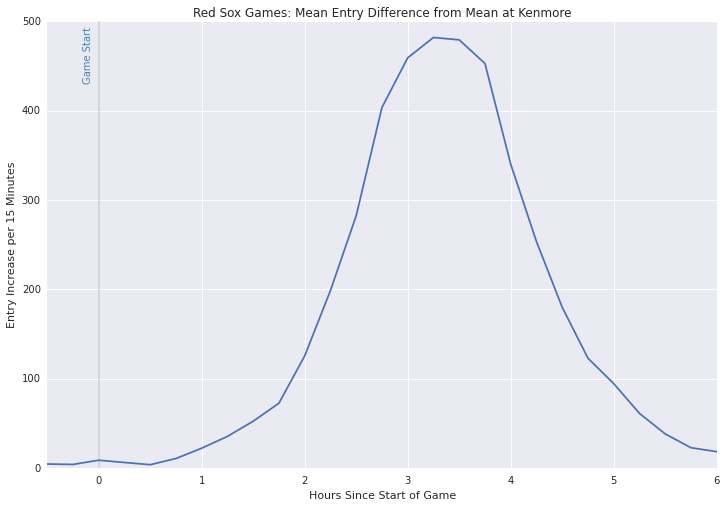

Mean increase in entries across time period: 4230.68094229


In [301]:
# Now plot them!
plt.figure(figsize=(12,8))
plt.plot(mean_entry_differences.hours_since_game_start, mean_entry_differences.entries_vs_mean['mean'])
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
plt.vlines(0, *ylim, colors='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean at Kenmore')
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
# Show.
plt.show()

# For added context, sum the mean difference.
print 'Mean increase in entries across time period:',mean_entry_differences.entries_vs_mean['mean'].sum()

Thus, on average we see a mean aggregate increase of **4,231** entries at Kenmore from 1 hour before the game until 6 hours after.

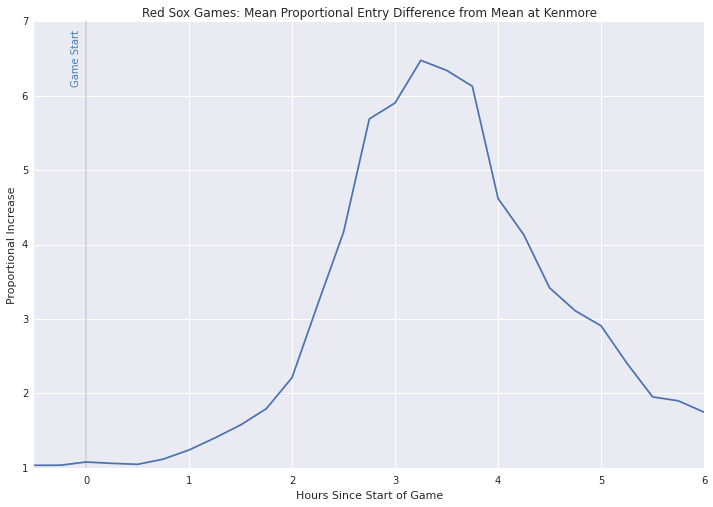

In [302]:
# Also plot the mean proportion change.
plt.figure(figsize=(12,8))
plt.plot(mean_entry_differences.hours_since_game_start, mean_entry_differences.entries_vs_mean_ratio['mean'])
# Fix x limit and add origin lines.
xlim = plt.xlim((-0.5, plt.xlim()[1])); ylim = plt.ylim()
plt.vlines(0, *ylim, colors='lightgray')
# plt.hlines(0, *xlim, colors='lightgray')
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')
# Prettify.
plt.title('Red Sox Games: Mean Proportional Entry Difference from Mean at Kenmore')
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Proportional Increase')
# Show.
plt.show()